# Fine tuning of Support Vector Classifier with RBF kernel

## for binary classification with independent datapoints

In [1]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, average_precision_score, classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)

# models
from sklearn.svm import SVC

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/binary_independent'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 10)
(2026, 10)
(8103,)
(2026,)


In [3]:
# numeric features that need transformation
real_features = ['mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound', 'co2', 'co2slope']

# scorer: Area under Precision-Recall curve (PR-AUC)
scorer = make_scorer(score_func=average_precision_score)

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
# kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

### Tuning with PCA

In [4]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = SVC(kernel='rbf', random_state=42)

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('dimred', PCA(random_state=42)),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(estimator, param_grid, factor=2, cv=kf, scoring=scorer, refit=True, verbose=1)
    search.fit(X_train, y_train)
        
    return search

In [48]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap - separate plot for each PCA n_component
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(subset=['param_model__C', 'param_model__gamma', 'param_dimred__n_components'], keep='last')
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False).astype(int)

    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    for n in df['param_dimred__n_components'].unique():
        print(f'\nPCA n_components = {n}')
        df_n = df[df['param_dimred__n_components'] == n]
        data = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
        annot = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='rank')
        sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot, fmt='d')
        plt.show()

In [8]:
param_grid = {
    'model__C': np.logspace(1, 5, num=5),
    'model__gamma': np.linspace(3.5, 5.0, 16),
    'dimred__n_components': [6, 7, 8],
}

search = get_search_results(X_train, y_train, param_grid)
search

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 240
n_resources: 200
Fitting 50 folds for each of 240 candidates, totalling 12000 fits
----------
iter: 1
n_candidates: 120
n_resources: 400
Fitting 50 folds for each of 120 candidates, totalling 6000 fits
----------
iter: 2
n_candidates: 60
n_resources: 800
Fitting 50 folds for each of 60 candidates, totalling 3000 fits
----------
iter: 3
n_candidates: 30
n_resources: 1600
Fitting 50 folds for each of 30 candidates, totalling 1500 fits
----------
iter: 4
n_candidates: 15
n_resources: 3200
Fitting 50 folds for each of 15 candidates, totalling 750 fits
----------
iter: 5
n_candidates: 8
n_resources: 6400
Fitting 50 folds for each of 8 candidates, totalling 400 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('scaler',
                                                                                                 MinMaxScaler())]),
                                                                                ['mintemp',
                                                                                 'maxtemp',
                                                                                 'minlight',
                                                                                 'maxlight',
                                                                                 'minsound',
                                                                                 'maxsound',
                                                                                 'co2',
                                                                                 'co2slope'])])),
                                              ('dimred', PCA(random_state=42)),
                                              ('model', SVC(random_state=42))]),
                    factor=2,
                    param_grid={'dimred__n_components': [6, 7, 8],
                                'model__C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
                                'model__gamma': array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. ])},
                    scoring=make_scorer(average_precision_score), verbose=1)

Best parameters:
{'dimred__n_components': 7, 'model__C': 100000.0, 'model__gamma': 4.8}

Best score:
0.9968672890377133


PCA n_components = 6


C:\Users\Judit\AppData\Local\Temp\ipykernel_17084\2537845070.py:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_17084\2537845070.py:18: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


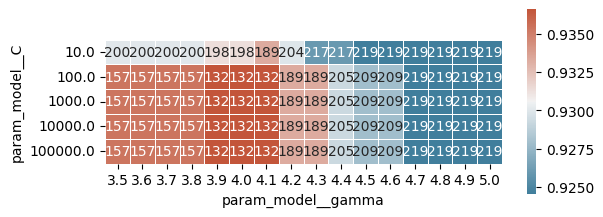


PCA n_components = 7


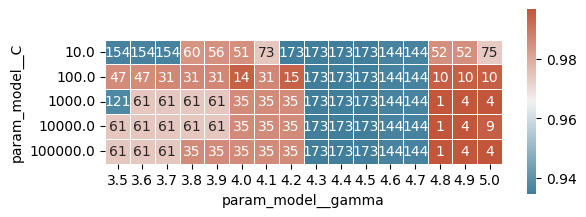


PCA n_components = 8


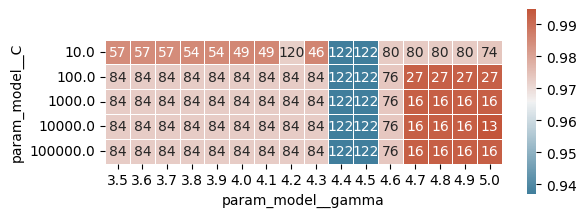

In [49]:
report_results(search)

### Fine-tuning for the most promising region (C: 1000-100,000; gamma: 4.5-5.5, n_components: 7)

In [51]:
param_grid = {
    'model__C': np.logspace(3, 5, num=6),
    'model__gamma': np.linspace(4.5, 5.5, 11),
    'dimred__n_components': [7],
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 66
n_resources: 200
Fitting 50 folds for each of 66 candidates, totalling 3300 fits
----------
iter: 1
n_candidates: 33
n_resources: 400
Fitting 50 folds for each of 33 candidates, totalling 1650 fits
----------
iter: 2
n_candidates: 17
n_resources: 800
Fitting 50 folds for each of 17 candidates, totalling 850 fits
----------
iter: 3
n_candidates: 9
n_resources: 1600
Fitting 50 folds for each of 9 candidates, totalling 450 fits
----------
iter: 4
n_candidates: 5
n_resources: 3200
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 5
n_candidates: 3
n_resources: 6400
Fitting 50 folds for each of 3 candidates, totalling 150 fits


Best parameters:
{'dimred__n_components': 7, 'model__C': 100000.0, 'model__gamma': 4.9}

Best score:
0.9968236067562555


PCA n_components = 7


C:\Users\Judit\AppData\Local\Temp\ipykernel_17084\2537845070.py:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_17084\2537845070.py:18: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


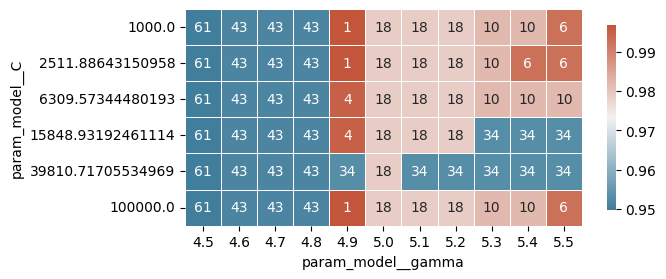

In [52]:
report_results(results)

### Fine-tuning for the most promising regions (C: 500-3000; gamma: 4.8-5.0) and (C: 100k-1m; gamma: 4.8-5.0)

In [68]:
param_grid = {
    'model__C': np.concatenate([np.linspace(500, 3000, num=26).astype(int), np.linspace(100_000, 1_000_000, num=10).astype(int)]),
    'model__gamma': np.linspace(4.8, 5.0, 3),
    'dimred__n_components': [7],
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 108
n_resources: 200
Fitting 50 folds for each of 108 candidates, totalling 5400 fits
----------
iter: 1
n_candidates: 54
n_resources: 400
Fitting 50 folds for each of 54 candidates, totalling 2700 fits
----------
iter: 2
n_candidates: 27
n_resources: 800
Fitting 50 folds for each of 27 candidates, totalling 1350 fits
----------
iter: 3
n_candidates: 14
n_resources: 1600
Fitting 50 folds for each of 14 candidates, totalling 700 fits
----------
iter: 4
n_candidates: 7
n_resources: 3200
Fitting 50 folds for each of 7 candidates, totalling 350 fits
----------
iter: 5
n_candidates: 4
n_resources: 6400
Fitting 50 folds for each of 4 candidates, totalling 200 fits


Best parameters:
{'dimred__n_components': 7, 'model__C': 2300, 'model__gamma': 4.8}

Best score:
0.9972278754578887


PCA n_components = 7


C:\Users\Judit\AppData\Local\Temp\ipykernel_17084\2537845070.py:17: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_17084\2537845070.py:18: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df_n.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


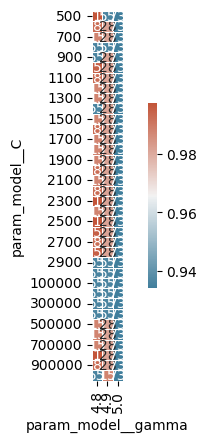

In [69]:
report_results(results)

## Best model cross-validation performance

In [70]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9972
Median: 0.9984
95% confidence interval: (0.9895 - 1.0000)


## Evaluate best model on hold-out test dataset

In [71]:
y_pred = results.best_estimator_.predict(X_test)

In [72]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      1646
           1     1.0000    0.9974    0.9987       380

    accuracy                         0.9995      2026
   macro avg     0.9997    0.9987    0.9992      2026
weighted avg     0.9995    0.9995    0.9995      2026



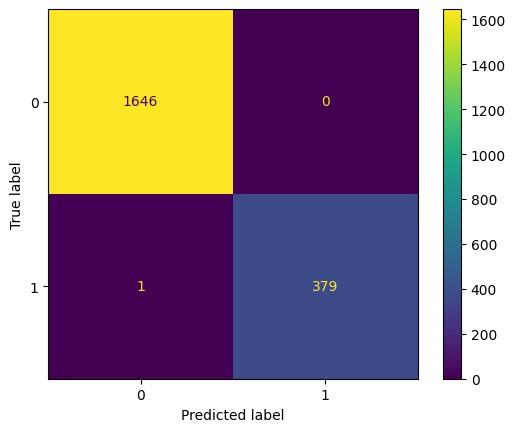

In [73]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

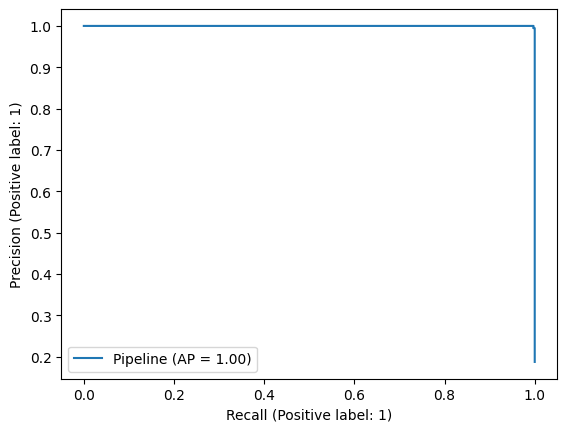

In [74]:
# Precision - Recall curve
PrecisionRecallDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

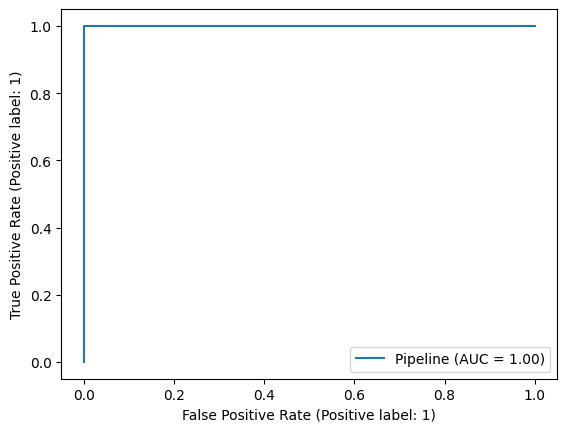

In [75]:
# ROC curve
RocCurveDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()